In [331]:
#Standard Imports
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Model
from sklearn.linear_model import LogisticRegression
import seaborn as sns

#Preprocessing 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#Model evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import statsmodels.api as sm

#Import data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Print data to see the format

In [332]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Check for any missing values

In [333]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Quick manual preprocessing 

In [334]:
#Remove unnecessary columns (customerID is an identifier)
df.drop(['customerID'], axis=1, inplace=True)

#Manually map churn column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#Convert TotalCharges to numeric from string
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Split into numeric and categorical features to apply different transformations

In [335]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

In [336]:
categorical_features = ['gender','SeniorCitizen','Partner',
                        'Dependents','PhoneService','MultipleLines','InternetService',
                        'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

In [337]:
preprocessor = ColumnTransformer([('numeric', numeric_transformer, numeric_features), ('categorical', categorical_transformer, categorical_features)])

Initialize X and Y + Split into Test/Train

In [338]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=1/9,          
    random_state=42,
    stratify=y_train_temp
)


Multiple Logistic Regression 

In [345]:
model = Pipeline([('preprocessor', preprocessor),
                  ('classifier', LogisticRegression(solver='liblinear', max_iter=500))])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier',
                 LogisticRegression(max_iter=500, solver='liblinear'))])

In [341]:
X_processed = model.named_steps['preprocessor'].transform(X)

# If sparse matrix → make dense
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

# Convert all columns to float
X_processed = X_processed.astype(float)

# Check for singular matrix by computing rank
from numpy.linalg import matrix_rank
rank = matrix_rank(X_processed)
n_features = X_processed.shape[1]

print(f"Matrix rank: {rank}, Number of features: {n_features}")

# Add intercept column first
X_sm = sm.add_constant(X_processed)

# -------------------------
# Fit statsmodels logistic regression
# -------------------------
try:
    logit_model = sm.Logit(y.astype(int), X_sm).fit()
    print(logit_model.summary())
except Exception as e:
    print(f"Error fitting model: {e}")
    print(f"Attempting to fit with regularization (L2 penalty)...")
    # Use sklearn's LogisticRegression with L2 regularization instead
    from sklearn.linear_model import LogisticRegression as LR
    lr_model = LR(solver='lbfgs', max_iter=1000, penalty='l2')
    lr_model.fit(X_processed, y.astype(int))
    print(f"Model fitted successfully with sklearn")
    print(f"Coefficients shape: {lr_model.coef_.shape}")
    print(f"Intercept: {lr_model.intercept_}")

Matrix rank: 24, Number of features: 30
Optimization terminated successfully.
         Current function value: 0.413898
         Iterations 8
Error fitting model: Singular matrix
Attempting to fit with regularization (L2 penalty)...
Model fitted successfully with sklearn
Coefficients shape: (1, 30)
Intercept: [-1.30249008]


In [342]:
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Accuracy :", val_accuracy)
print("Precision:", val_precision)
print("Recall   :", val_recall)
print("F1 Score :", val_f1)

Accuracy : 0.8028368794326242
Precision: 0.6558441558441559
Recall   : 0.5401069518716578
F1 Score : 0.592375366568915


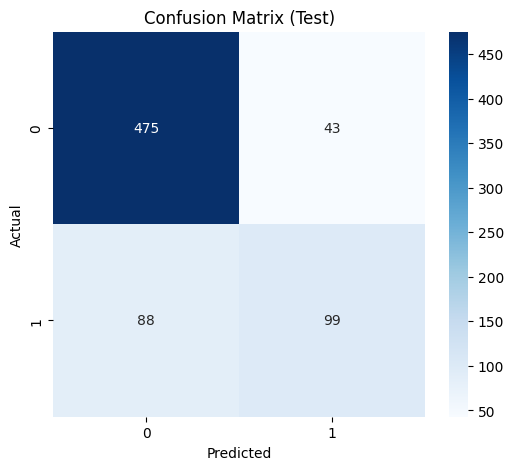

In [343]:
y_test_pred = model.predict(X_test)

y_test_prob = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
sample_df = X_test.copy()
sample_df['Actual'] = y_test
sample_df['Predicted'] = y_test_pred
sample_df['Probability'] = y_test_prob
display(sample_df.head(5))


SAMPLE PREDICTIONS


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Probability
402,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,0,0.266984
1292,Female,0,No,No,62,Yes,Yes,DSL,No,Yes,...,Yes,Yes,Two year,No,Bank transfer (automatic),84.50,5193.20,0,0,0.021664
1175,Female,0,No,No,13,Yes,Yes,Fiber optic,Yes,No,...,No,No,Month-to-month,Yes,Credit card (automatic),80.00,1029.35,0,0,0.476994
4600,Male,0,Yes,Yes,56,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Two year,No,Mailed check,115.85,6567.90,0,0,0.047767
3464,Female,0,Yes,No,31,Yes,No,Fiber optic,No,Yes,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),83.85,2674.15,0,0,0.407121
